# Exploring ConvNet Activations

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaivimalik/covid_illegitimate_features/blob/main/notebooks/Exploring_ConvNet_Activations.ipynb)

In [ ]:
# Uncomment the following lines if running on Google Colab
#!git clone https://github.com/shaivimalik/covid_illegitimate_features.git
#!pip install -r covid_illegitimate_features/requirements.txt
#%cd covid_illegitimate_features/notebooks

In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
np.random.seed(20)
import tensorflow as tf
tf.random.set_seed(20)

In [111]:
# Define image size and batch size
image_size = (256,256)
batch_size = 4

# Load the dataset from directory
dataset_leak = keras.utils.image_dataset_from_directory(
    '../different_backgrounds', 
    label_mode="categorical", 
    image_size=image_size, 
    batch_size=batch_size
)

# Split the dataset into train, validation, and test sets (70-10-20)
train_ds_leak = dataset_leak.take(tf.data.experimental.cardinality(dataset_leak).numpy()*0.7)
remaining_ds_leak = dataset_leak.skip(tf.data.experimental.cardinality(dataset_leak).numpy()*0.7)
val_ds_leak = remaining_ds_leak.take(tf.data.experimental.cardinality(dataset_leak).numpy()*0.1)
test_ds_leak = remaining_ds_leak.skip(tf.data.experimental.cardinality(dataset_leak).numpy()*0.2)

Found 100 files belonging to 2 classes.


In [112]:
# Define data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]
# Function to apply data augmentation
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply data augmentation to training dataset
train_ds_leak = train_ds_leak.map(lambda img, label: (data_augmentation(img), label),num_parallel_calls=tf.data.AUTOTUNE)
# Prefetch test and validation datasets for performance
test_ds_leak = test_ds_leak.prefetch(tf.data.AUTOTUNE)
val_ds_leak = val_ds_leak.prefetch(tf.data.AUTOTUNE)

In [120]:
num_classes = 2

# Create model
model_leak = keras.Sequential()

# Add input layer
model_leak.add(keras.Input(shape=image_size + (3,)))

# Add rescaling layer to normalize pixel values
model_leak.add(layers.Rescaling(scale=1./255))

# Add convolutional and pooling layers
model_leak.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid", activation='relu', use_bias=True))
model_leak.add(layers.MaxPooling2D(pool_size=(2, 2),padding="valid"))
model_leak.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid", activation='relu', use_bias=True))
model_leak.add(layers.MaxPooling2D(pool_size=(2, 2),padding="valid"))
model_leak.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid", activation='relu', use_bias=True))
model_leak.add(layers.MaxPooling2D(pool_size=(2, 2),padding="valid"))

# Flatten the output and add dense layers
model_leak.add(layers.Flatten())
model_leak.add(layers.Dense(64, activation='relu'))
model_leak.add(layers.Dense(num_classes,activation="softmax"))

model_leak.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │       196,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,609 (768.00 KB)

 Trainable params: 196,609 (768.00 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
epochs = 10

# Compile the model
model_leak.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history_leak = model_leak.fit(train_ds_leak, batch_size=batch_size, epochs=epochs, validation_data=val_ds_leak)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)

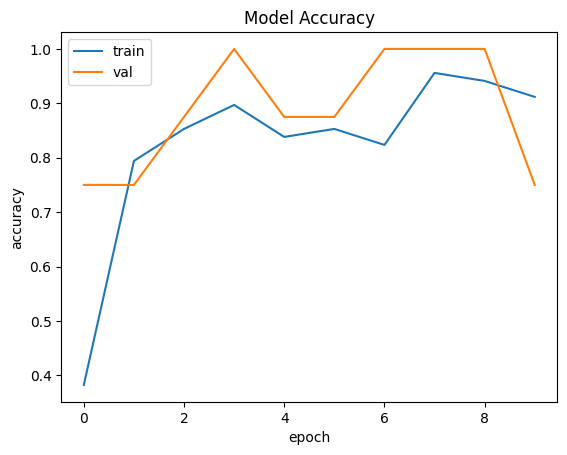

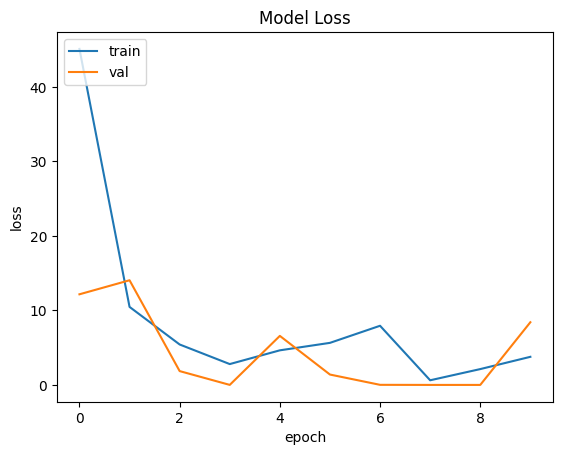

In [115]:
# summarize history for accuracy
plt.plot(history_leak.history['accuracy'])
plt.plot(history_leak.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_leak.history['loss'])
plt.plot(history_leak.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [122]:
# Evaluate the model on test data
score = model_leak.evaluate(test_ds_leak)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

/opt/anaconda3/envs/preterm_birth/lib/python3.12/site-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)

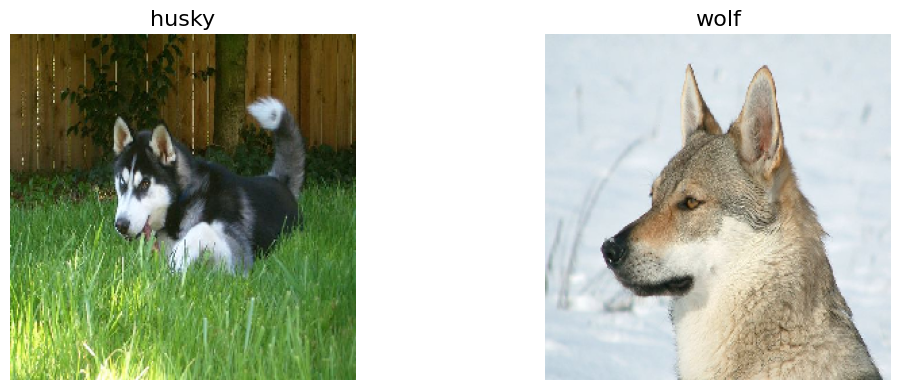

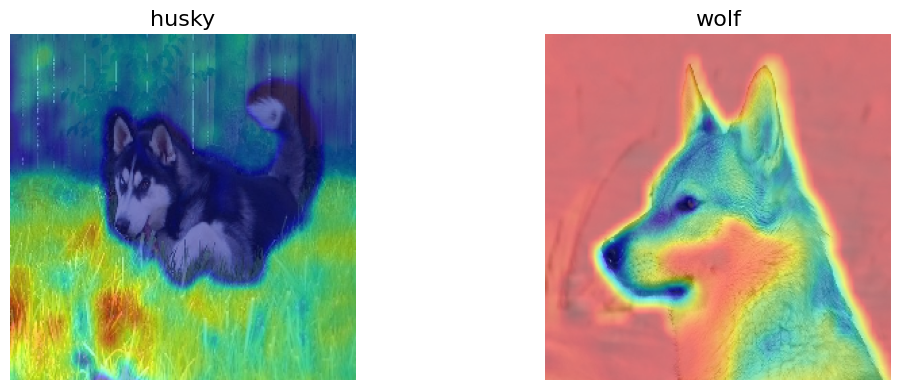

In [104]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Define image titles for visualization
image_titles = ['husky', 'wolf']

# Create lists of file paths for husky and wolf images
husky_files = np.array(['../different_backgrounds/husky/'+x for x in os.listdir('../different_backgrounds/husky')])
wolf_files = np.array(['../different_backgrounds/wolf/'+x for x in os.listdir('../different_backgrounds/wolf')])

# Load random images for each class and convert them to a Numpy array
husky = keras.utils.load_img(np.random.choice(husky_files), target_size=image_size)
wolf = keras.utils.load_img(np.random.choice(wolf_files), target_size=image_size)
images = np.asarray([np.array(husky), np.array(wolf)])
X = np.array([keras.utils.img_to_array(img) for img in images])

# Render the original images
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Define a function to modify the model for GradCAM
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = keras.activations.linear

# Define a score function for GradCAM
def score_function(output):
    return (output[0,0], output[1,1])

# Create Gradcam object
gradcam = Gradcam(model_leak, model_modifier=model_modifier_function, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score_function, X)

# Render the images with GradCAM heatmaps overlaid
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [125]:
# Evaluate the model on test data
background_swap = keras.utils.image_dataset_from_directory(
    '../background_swap', 
    label_mode="categorical", 
    image_size=image_size, 
    batch_size=batch_size
)
score = model_leak.evaluate(background_swap)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 40 files belonging to 2 classes.


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)

In [126]:
# Define image size and batch size
image_size = (256,256)
batch_size = 4

# Load the dataset from directory
dataset = keras.utils.image_dataset_from_directory(
    '../same_backgrounds', 
    label_mode="categorical", 
    image_size=image_size, 
    batch_size=batch_size
)

# Split the dataset into train, validation, and test sets (70-10-20)
train_ds = dataset.take(tf.data.experimental.cardinality(dataset).numpy()*0.7)
remaining_ds = dataset.skip(tf.data.experimental.cardinality(dataset).numpy()*0.7)
val_ds = remaining_ds.take(tf.data.experimental.cardinality(dataset).numpy()*0.1)
test_ds = remaining_ds.skip(tf.data.experimental.cardinality(dataset).numpy()*0.1)

Found 100 files belonging to 2 classes.


In [127]:
# Define data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply data augmentation to training dataset
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label),num_parallel_calls=tf.data.AUTOTUNE)
# Prefetch test and validation datasets for performance
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [128]:
num_classes = 2

# Create the model
model = keras.Sequential()

# Add input layer
model.add(keras.Input(shape=image_size + (3,)))

# Add rescaling layer to normalize pixel values
model.add(layers.Rescaling(scale=1./255))

# Add convolutional and pooling layers
'''
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid", activation='relu', use_bias=True))
model.add(layers.MaxPooling2D(pool_size=(2, 2),padding="valid"))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid", activation='relu', use_bias=True))
model.add(layers.MaxPooling2D(pool_size=(2, 2),padding="valid"))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid", activation='relu', use_bias=True))
model.add(layers.MaxPooling2D(pool_size=(2, 2),padding="valid"))
'''
# Flatten the output and add dense layers
model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │       393,218 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,218 (1.50 MB)

 Trainable params: 393,218 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=val_ds)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4897 - loss: 60.9474 - val_accuracy: 0.7500 - val_loss: 4.8645
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4653 - loss: 24.2490 - val_accuracy: 0.5000 - val_loss: 20.5306
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6137 - loss: 59.7622 - val_accuracy: 0.3750 - val_loss: 52.4676
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3470 - loss: 51.3124 - val_accuracy: 0.6250 - val_loss: 16.4169
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5387 - loss: 44.7924 - val_accuracy: 0.6250 - val_loss: 38.1844
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7060 - loss: 14.3095 - val_accuracy: 0.3750 - val_loss: 42.7455
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4928 - loss: 29.7930 - val_accuracy: 0.7500 - val_loss: 9.4380
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4355 - loss: 67.0336 - val_accuracy: 0.6

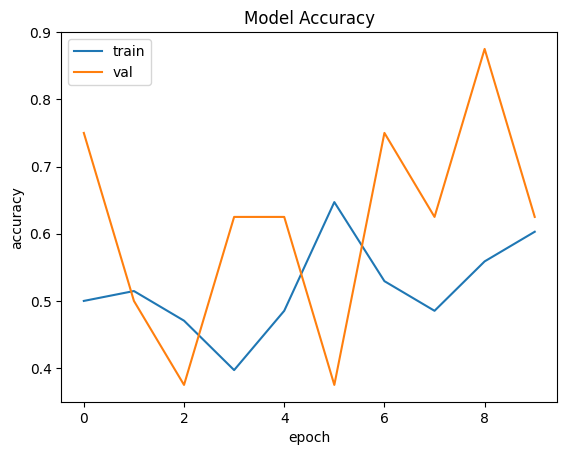

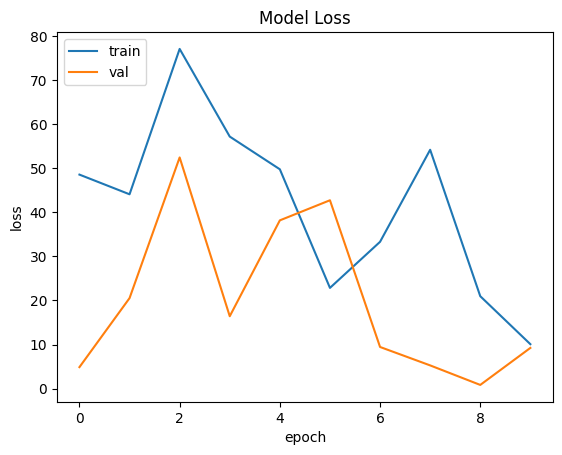

In [130]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [136]:
# Evaluate the model on test data
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5685 - loss: 14.9972 
Test loss: 13.422219276428223
Test accuracy: 0.5833333134651184


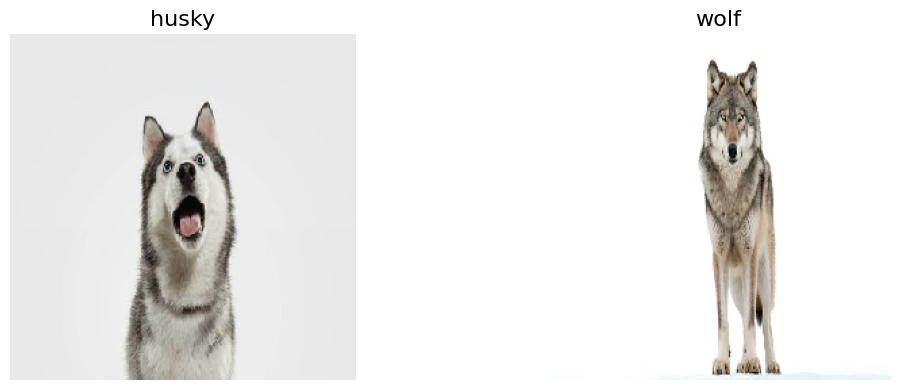

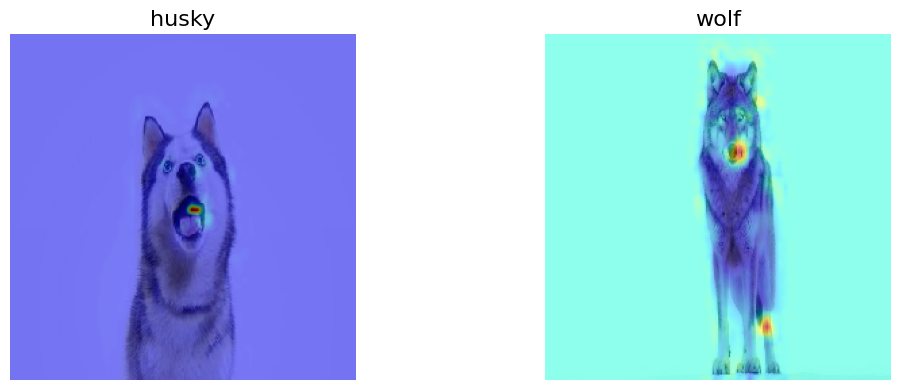

In [100]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Define image titles for visualization
image_titles = ['husky', 'wolf']

# Create lists of file paths for husky and wolf images
husky_files = np.array(['../same_backgrounds/husky/'+x for x in os.listdir('../same_backgrounds/husky')])
wolf_files = np.array(['../same_backgrounds/wolf/'+x for x in os.listdir('../same_backgrounds/wolf')])

# Load random images for each class and convert them to a Numpy array
husky = keras.utils.load_img(np.random.choice(husky_files), target_size=image_size)
wolf = keras.utils.load_img(np.random.choice(wolf_files), target_size=image_size)
images = np.asarray([np.array(husky), np.array(wolf)])
X = np.array([keras.utils.img_to_array(img) for img in images])

# Render the original images
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Define a function to modify the model for GradCAM
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = keras.activations.linear

# Define a score function for GradCAM
def score_function(output):
    return (output[0,0], output[1,1])

# Create Gradcam object
gradcam = Gradcam(model, model_modifier=model_modifier_function, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score_function, X)

# Render the images with GradCAM heatmaps overlaid
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()